In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [3]:
device

device(type='cpu')

## The MNIST Dataset

we need 4 segments of data for the MNIST dataset:

1. `x_train`: Images used for training the neural network
2. `y_train`: Correct labels for the `x_train` images, used to evaluate the model's predictions during training
3. `x_valid`: Images set aside for validating the performance of the model after it has been trained
4. `y_valid`: Correct labels for the `x_valid` images, used to evaluate the model's predictions after it has been trained

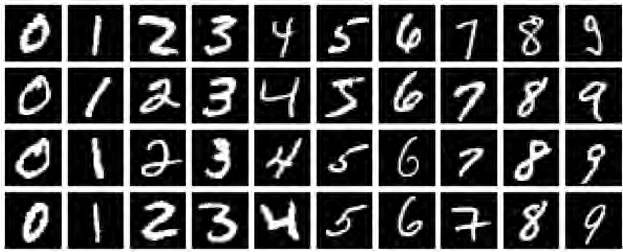

In [4]:
# transforms.ToTensor() will be deprecated...
transform = transforms.Compose([
    transforms.ToTensor(),  # (0~255) → (0.0~1.0)
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # 평균 0, 분산 1로 정규화
])

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
transform = transforms.Compose([
    transforms.ToImage(),  # PIL/ndarray → torch.uint8 tensor
    transforms.ToDtype(torch.float32, scale=True),  # uint8 → float32 in [0, 1]
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # 평균 0, 분산 1로 정규화

])

In [6]:
train_set = datasets.MNIST("./data/", train=True, download=True, transform=transform)
valid_set = datasets.MNIST("./data/", train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.25MB/s]


In [7]:
train_set, train_set.data.size(), type(train_set)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data/
     Split: Train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  ToDtype(scale=True)
                  Normalize(mean=[0.1307], std=[0.3081], inplace=False)
            ),
 torch.Size([60000, 28, 28]),
 torchvision.datasets.mnist.MNIST)

In [8]:
train_set.data.shape, train_set.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [9]:
type(train_set[0])

tuple

In [10]:
x_0, y_0 = train_set[0]
x_0.shape, y_0

(torch.Size([1, 28, 28]), 5)

In [11]:
for x, y in train_set:
    print(x.shape, y)
    break

torch.Size([1, 28, 28]) 5


In [12]:
np.unique(train_set.targets)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## squeeze() / unsqueeze()

In [13]:
x_0.shape, x_0.squeeze().shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

In [14]:
x_0_sq = x_0.squeeze()
x_0_sq.shape

torch.Size([28, 28])

In [15]:
x_0_sq.unsqueeze(0).shape

torch.Size([1, 28, 28])

In [16]:
x_0_sq.unsqueeze(1).shape

torch.Size([28, 1, 28])

In [17]:
x_0_sq.unsqueeze(2).shape

torch.Size([28, 28, 1])

## 데이터 시각화 (y_0=5)

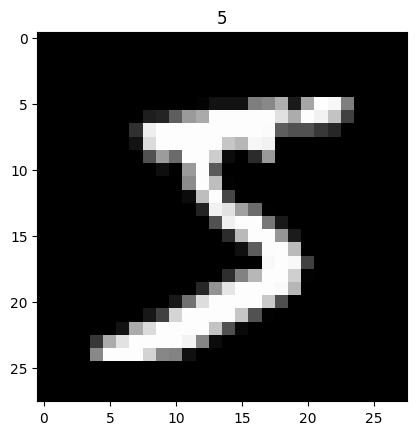

In [18]:
plt.title(y_0)
plt.imshow(x_0.squeeze(), cmap='gray')  # x_0
plt.show()

In [19]:
def imshow(imgTensor):
    plt.imshow(imgTensor.squeeze(), cmap='gray')
    plt.show()

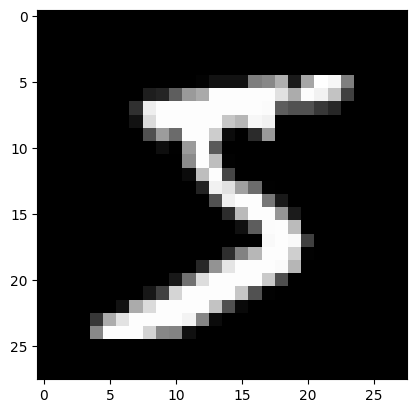

In [20]:
imshow(x_0)

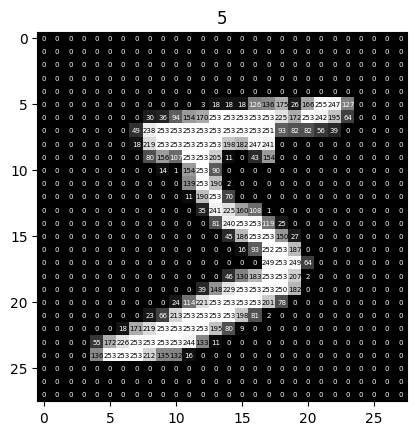

In [21]:
fig, ax = plt.subplots()
ax.imshow(train_set.data[0], cmap='gray')

for i in range(train_set.data[0].shape[0]):
    for j in range(train_set.data[0].shape[1]):
        c = 1 if train_set.data[0][i, j].item() < 128 else 0
        ax.text(j, i, str(train_set.data[0][i, j].item()), color=(c, c, c), ha='center', va='center',fontsize=5)

plt.title('%i' % train_set.targets[0])
plt.show()

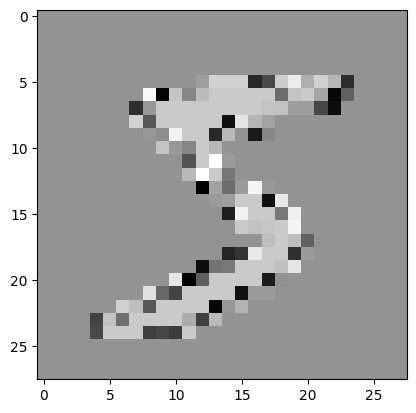

In [22]:
# PIL : pillow image
# PIL → 자동으로 uint8, [0, 255] 변환됨, 사람 눈에 익숙한 밝기로 출력됨
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

## DataLoader

In [23]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [24]:
for (x, y) in train_loader:
    print('x_train:', x.size(), 'type:', x.type())
    print('y_train:', y.size(), 'type:', y.type())
    break

for (x, y) in valid_loader:
    print('x_valid:', x.size(), 'type:', x.type())
    print('y_valid:', y.size(), 'type:', y.type())
    break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
x_valid: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_valid: torch.Size([32]) type: torch.LongTensor


In [25]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Creating the Model

In [26]:
test_matrix = torch.tensor(
    [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]
)
print(test_matrix)
print(test_matrix.size())

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
torch.Size([3, 3])


## unsqueeze()로 btach 차원 늘이기

In [27]:
# nn.Flatten()은 PyTorch의 신경망 모듈로, 입력 텐서를 평평하게 만드는 데 사용됨.
# 하지만 기본적으로 배치 차원(첫 번째 차원)은 평평하게 만들지 않음.
# 즉, nn.Flatten()은 입력 텐서의 배치 차원을 유지하면서 나머지 차원을 하나의 차원으로 평평하게 만듬
# test_matrix는 2차원 텐서이므로 배치 차원이 없습니다.
# 따라서 nn.Flatten()을 적용해도 텐서의 모양이 변경되지 않습니다.

nn.Flatten()(test_matrix)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [28]:
nn.Flatten()(test_matrix).shape

torch.Size([3, 3])

In [29]:
batch_test_matrix = test_matrix.unsqueeze(0)
batch_test_matrix, batch_test_matrix.shape

(tensor([[[1, 2, 3],
          [4, 5, 6],
          [7, 8, 9]]]),
 torch.Size([1, 3, 3]))

In [30]:
nn.Flatten()(batch_test_matrix)

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [31]:
batch_test_matrix = test_matrix[None, :]  # 배열의 가장 앞쪽에 새로운 차원 추가, 3차원 배열로 변환
batch_test_matrix

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [32]:
print(test_matrix.size())       # size()는 shape과 같은 기능
print(batch_test_matrix.size())

torch.Size([3, 3])
torch.Size([1, 3, 3])


In [33]:
nn.Flatten()(batch_test_matrix), nn.Flatten()(batch_test_matrix).size()

(tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]]), torch.Size([1, 9]))

In [34]:
# 배치 차원 추가
batch_test_matrix = test_matrix.unsqueeze(0)
print(batch_test_matrix, batch_test_matrix.size())

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]]) torch.Size([1, 3, 3])


In [35]:
# Flatten 적용
flattened_matrix = nn.Flatten()(batch_test_matrix)

print(flattened_matrix.shape)  # torch.Size([1, 9])
print(flattened_matrix)

torch.Size([1, 9])
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])


## Neural Network Definition

* ### CrossEntropyLoss(logits, targets) == NLLLoss(log(softmax(logits)), targets)

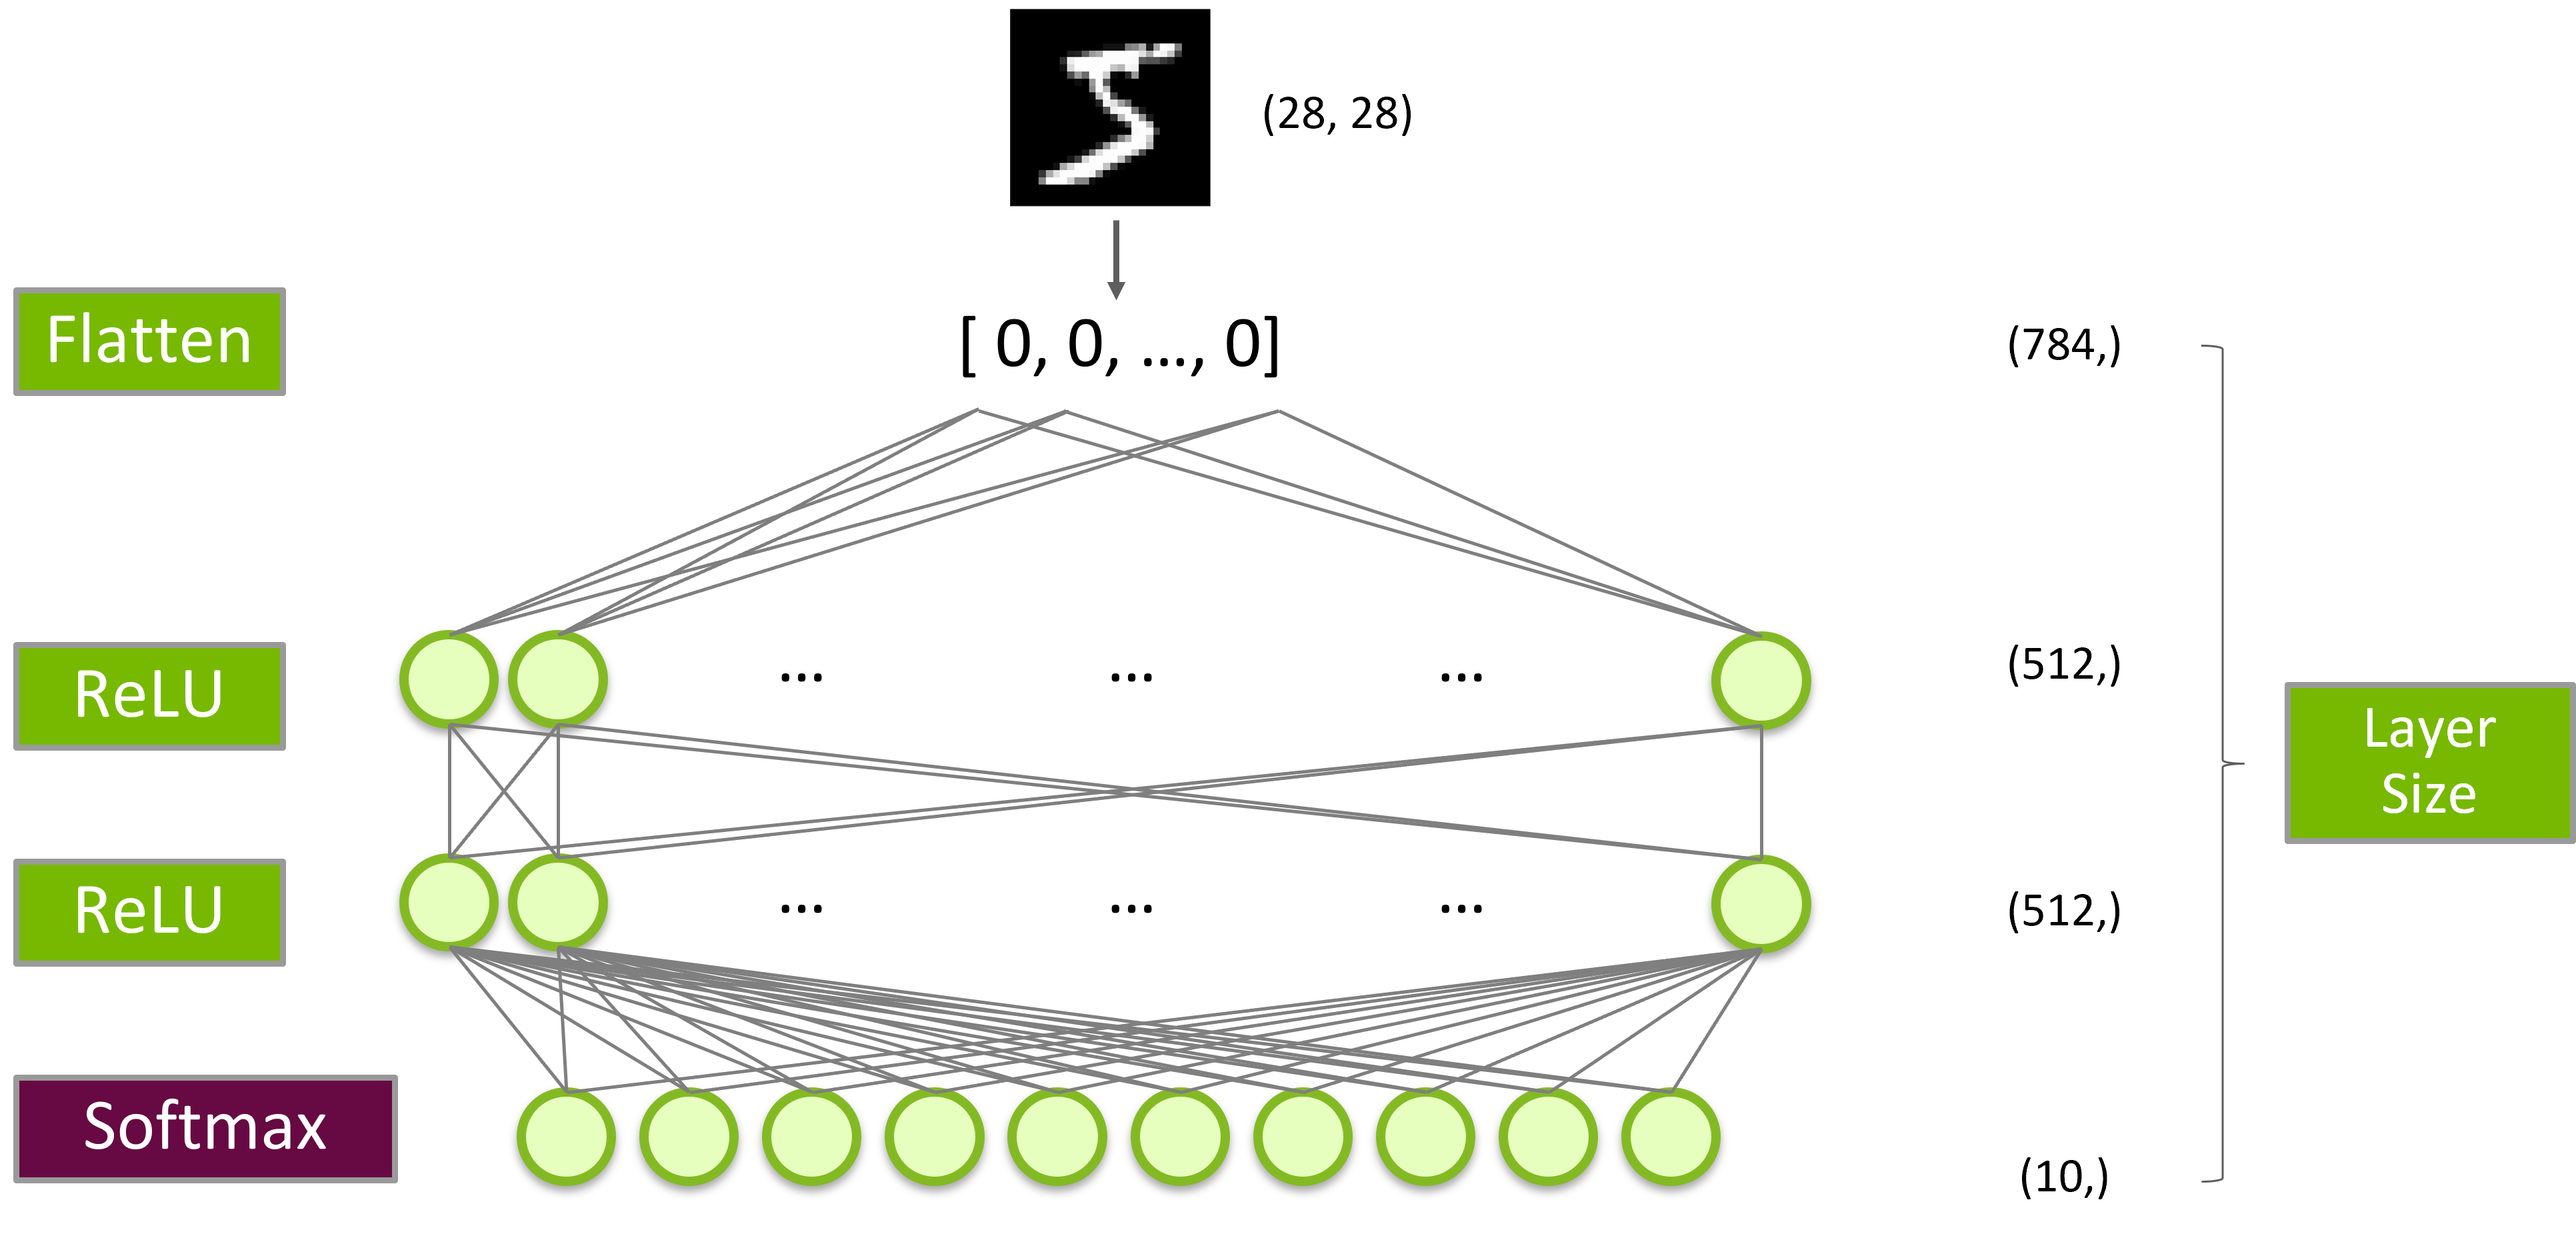

In [36]:
input_size = 1 * 28 * 28

In [37]:
n_classes = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, n_classes)
)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

## load the Model to GPU

In [38]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

## Training the Model

#### Loss and Optimization

In [39]:
loss_function = nn.CrossEntropyLoss()

In [40]:
optimizer = Adam(model.parameters())

### Calculation Accuarcy

In [41]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)  # 예측값

    # view_as(pred)는 y 텐서를 pred 텐서와 동일한 모양으로 바꿈, item : Scalar 값 추출
    correct = pred.eq(y.view_as(pred)).sum().item()

    return correct / N

In [42]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)
print(train_N)
print(valid_N)

60000
10000


### The Train Function

In [43]:
size = len(train_loader.dataset)
print(size)

print(len(train_loader))

num_batches = len(train_loader)
print(num_batches)

print(size/batch_size)

60000
1875
1875
1875.0


In [44]:
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = 0.0, 0.0
    train_correct, val_correct = 0.0, 0.0

    model.train() # prepare model for training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # initialize the gradients
        optimizer.zero_grad()
        # forward pass: compute predicted outputs
        output = model(inputs)
        # calculate the loss
        loss = loss_function(output, labels)
        # backward pass: compute gradient
        loss.backward()
        # perform a optimization step (weight update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()

        # training accuracy
        train_correct += get_batch_accuracy(output, labels, len(train_loader.dataset))

    model.eval() # validate the model
    # val_correct = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = loss_function(output, labels)
            val_loss += loss.item()

            # valid accuracy
            val_correct += get_batch_accuracy(output, labels, len(valid_loader.dataset))

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accs.append(train_correct)
    val_accs.append(val_correct)

    print('Epoch: {}   Training Loss: {:.6f}    Valid Loss: {:.6f}    Training Accuracy: {:.3f}%    Valid Accuracy:{:.2f}%'.format(
        epoch, train_loss, val_loss, 100. * train_correct, 100. * val_correct))

Epoch: 1   Training Loss: 0.198898    Valid Loss: 0.134107    Training Accuracy: 93.813%    Valid Accuracy:95.73%
Epoch: 2   Training Loss: 0.093714    Valid Loss: 0.088464    Training Accuracy: 97.143%    Valid Accuracy:97.30%
Epoch: 3   Training Loss: 0.069640    Valid Loss: 0.097112    Training Accuracy: 97.858%    Valid Accuracy:97.08%
Epoch: 4   Training Loss: 0.055153    Valid Loss: 0.112022    Training Accuracy: 98.268%    Valid Accuracy:96.66%
Epoch: 5   Training Loss: 0.046930    Valid Loss: 0.085865    Training Accuracy: 98.558%    Valid Accuracy:97.78%
Epoch: 6   Training Loss: 0.039695    Valid Loss: 0.110451    Training Accuracy: 98.753%    Valid Accuracy:97.52%
Epoch: 7   Training Loss: 0.040091    Valid Loss: 0.083780    Training Accuracy: 98.783%    Valid Accuracy:97.93%
Epoch: 8   Training Loss: 0.032123    Valid Loss: 0.113905    Training Accuracy: 99.040%    Valid Accuracy:97.65%
Epoch: 9   Training Loss: 0.031730    Valid Loss: 0.142159    Training Accuracy: 99.060%

## Visualization of Train Results

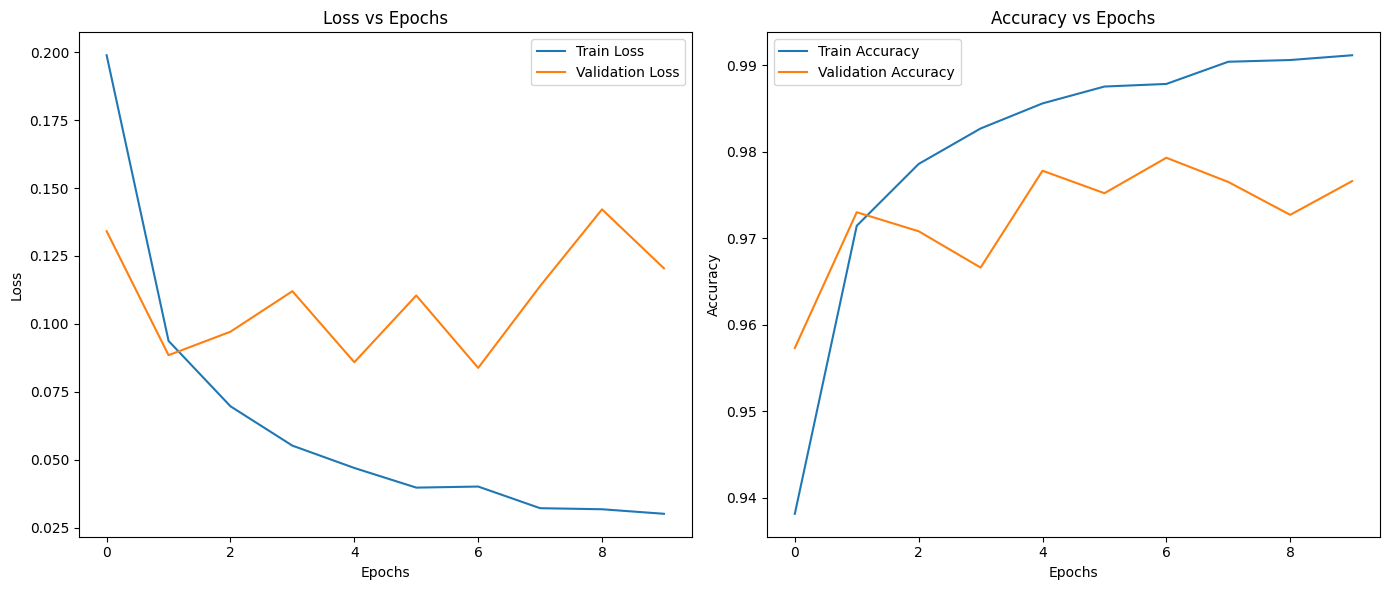

In [45]:
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## get_batch_accuracy(), train(), validate() 함수로 구현

### The Train Function

In [46]:
train_losses, train_accuracies = [],[]

def train():
    train_loss = 0.0
    train_correct = 0.0

    model.train()

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        # 새로운 배치(batch)로 학습을 진행하기 전에 이전 배치에서 계산된 기울기 값을 0으로 초기화
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        # # 배치별 오차를 누적하여 전체 오차를 계산
        train_loss += batch_loss.item()
        # 배치별 정확도를 누적하여 전체 정확도를 계산
        train_correct += get_batch_accuracy(output, y, train_N)

    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    train_losses.append('{:.3f}'.format(train_loss))

    train_accuracies.append('{:.2f}'.format(train_correct))

    print('Train - Loss: {:.3f} Accuracy: {:.3f} %'.format(train_loss, train_correct))

In [47]:
len(train_loader), len(valid_loader), len(train_loader), len(valid_loader), 60000/32, 10000/32

(1875, 313, 1875, 313, 1875.0, 312.5)

### The Validation Function

In [48]:
len(valid_loader)

313

In [49]:
valid_losses, valid_accuracies = [],[]

def validate():
    val_loss = 0.0
    val_correct = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            batch_loss = loss_function(output, y)
            val_loss += batch_loss.item()

            val_correct += get_batch_accuracy(output, y, valid_N)

    val_loss = val_loss/len(valid_loader)
    valid_losses.append(val_loss)

    valid_accuracies.append(val_correct)

    print('Valid - Loss: {:.3f} Accuracy: {:.3f} %'.format(val_loss, val_correct))

### The Training Loop

In [50]:
epochs = 10

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 0.028 Accuracy: 0.992 %
Valid - Loss: 0.143 Accuracy: 0.971 %
Epoch: 1
Train - Loss: 0.028 Accuracy: 0.992 %
Valid - Loss: 0.121 Accuracy: 0.978 %
Epoch: 2
Train - Loss: 0.027 Accuracy: 0.992 %
Valid - Loss: 0.159 Accuracy: 0.978 %
Epoch: 3
Train - Loss: 0.025 Accuracy: 0.994 %
Valid - Loss: 0.137 Accuracy: 0.979 %
Epoch: 4
Train - Loss: 0.023 Accuracy: 0.994 %
Valid - Loss: 0.169 Accuracy: 0.977 %
Epoch: 5
Train - Loss: 0.027 Accuracy: 0.994 %
Valid - Loss: 0.170 Accuracy: 0.976 %
Epoch: 6
Train - Loss: 0.018 Accuracy: 0.996 %
Valid - Loss: 0.167 Accuracy: 0.976 %
Epoch: 7


KeyboardInterrupt: 

## Visualization

In [ ]:
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Model Save & Load

### Model Save

In [ ]:
# 모델 저장 (마지막 에폭 후 저장), 나중에 예측 또는 테스트에 사용
torch.save(model.state_dict(), "./model/my_MNIST_model.pth")
print("model saved: my_MNIST_model.pth")

### Model Load

In [ ]:
# 같은 모델 구조 정의
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, n_classes)
)

# 디바이스 설정
model.to(device)

In [ ]:
# 저장된 가중치 로드
# map_location=device : 원하는 디바이스로 모델 데이터를 매핑하는 역할
model.load_state_dict(torch.load("./model/my_MNIST_model.pth", map_location=device))
model.eval()
print("Successively loaded Model")
print(model)

## Prediction

In [ ]:
x_0.shape, y_0

In [ ]:
x_0.device

In [ ]:
x_0_gpu = x_0.cuda()
x_0_gpu.device

In [ ]:
prediction = model(x_0_gpu)
prediction

In [ ]:
x_0_tensor = transform(x_0)

In [ ]:
x_0_tensor.size(), x_0_tensor.type, type(x_0_tensor)

In [ ]:
# By default, a tensor is processed with a CPU
x_0_tensor.device

In [ ]:
x_0_gpu = x_0_tensor.cuda()
x_0_gpu.device

In [ ]:
prediction = model(x_0_gpu)
prediction

In [ ]:
prediction.argmax(dim=1, keepdim=True)

In [ ]:
y_0

In [ ]:
print(x_0_gpu.shape)
print(x_0_gpu.squeeze(0).shape)

In [ ]:
plt.title("Label : " + str(y_0))
plt.imshow(x_0_gpu.cpu().squeeze(0), cmap='gray')
plt.show()